---
## 1️⃣ Import Library & Setup

Library yang digunakan:
- **NumPy**: Operasi matriks dan aljabar linear
- **OpenCV**: Image processing
- **Matplotlib & Seaborn**: Visualisasi data
- **Scikit-learn**: Machine learning (SVM, metrics)

In [6]:
import numpy as np
import cv2
import os
import glob
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Changed from tqdm.notebook to regular tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Library berhasil di-import!")
print(f"📦 NumPy version: {np.__version__}")
print(f"📦 OpenCV version: {cv2.__version__}")

✅ Library berhasil di-import!
📦 NumPy version: 2.2.6
📦 OpenCV version: 4.12.0


---
## 2️⃣ Definisi Fungsi FFT & Feature Extraction

### 📐 Konsep Matematika:

**Fast Fourier Transform (FFT):**
$$F(u,v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x,y) e^{-j2\pi(\frac{ux}{M} + \frac{vy}{N})}$$

**Magnitude Spectrum:**
$$|F(u,v)| = \sqrt{\text{Re}(F(u,v))^2 + \text{Im}(F(u,v))^2}$$

**Azimuthal Average (Reduksi Dimensi 2D → 1D):**
$$P(r) = \frac{1}{N_r} \sum_{(u,v) \in r} |F(u,v)|$$

Di mana $r = \sqrt{u^2 + v^2}$ adalah jarak radial dari pusat spektrum.

In [2]:
# Konfigurasi Global
FIXED_SIZE = (512, 512)  # Ukuran standar resize

def azimuthalAverage(image, center=None):
    """
    Menghitung rata-rata radial dari spektrum frekuensi 2D.
    Mengubah gambar 2D menjadi grafik garis 1D.
    
    Parameters:
    -----------
    image : numpy.ndarray
        Spektrum frekuensi 2D (magnitude spectrum)
    center : tuple, optional
        Koordinat pusat (x, y). Jika None, akan menggunakan center image.
    
    Returns:
    --------
    radialprofile : numpy.ndarray
        Vektor 1D dari rata-rata radial
    """
    y, x = image.shape
    if not center:
        center = np.array([x//2, y//2])

    # Buat grid koordinat
    xx, yy = np.meshgrid(np.arange(x), np.arange(y))
    
    # Hitung jarak setiap piksel ke pusat (Radius)
    # r(x,y) = sqrt((x - cx)^2 + (y - cy)^2)
    r = np.sqrt((xx - center[0])**2 + (yy - center[1])**2)
    r = r.astype(int)

    # Jumlahkan energi per radius (Binning)
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())
    
    # Rata-rata (hindari pembagian nol)
    radialprofile = tbin / np.maximum(nr, 1)
    return radialprofile

def extract_features(image_path):
    """
    PIPELINE UTAMA:
    1. Load Image → Grayscale Matrix
    2. Resize (Normalisasi Dimensi)
    3. FFT (Transformasi Basis)
    4. Log Magnitude (Scaling)
    5. Azimuthal Average (Vektorisasi 2D→1D)
    
    Parameters:
    -----------
    image_path : str
        Path ke file gambar
    
    Returns:
    --------
    psd1D : numpy.ndarray
        Vektor fitur 1D (Power Spectral Density)
    """
    try:
        # 1. Load & Resize
        img = cv2.imread(image_path, 0)  # Grayscale
        if img is None: 
            return None
        img = cv2.resize(img, FIXED_SIZE)

        # 2. FFT (2D Fourier Transform)
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)  # Shift zero frequency ke center
        
        # 3. Log Magnitude Spectrum
        # 20*log10(|F|) untuk membuat skala lebih readable
        magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1e-10)

        # 4. Azimuthal Integration (2D → 1D)
        psd1D = azimuthalAverage(magnitude_spectrum)
        
        # Buang DC component (titik 0 yang nilainya sangat besar)
        return psd1D[1:] 
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

print("✅ Fungsi FFT dan Feature Extraction siap!")

✅ Fungsi FFT dan Feature Extraction siap!


---
## 3️⃣ Visualisasi Transformasi FFT

Visualisasi step-by-step proses transformasi dari domain spasial ke domain frekuensi.

🔍 Visualisasi REAL Image:


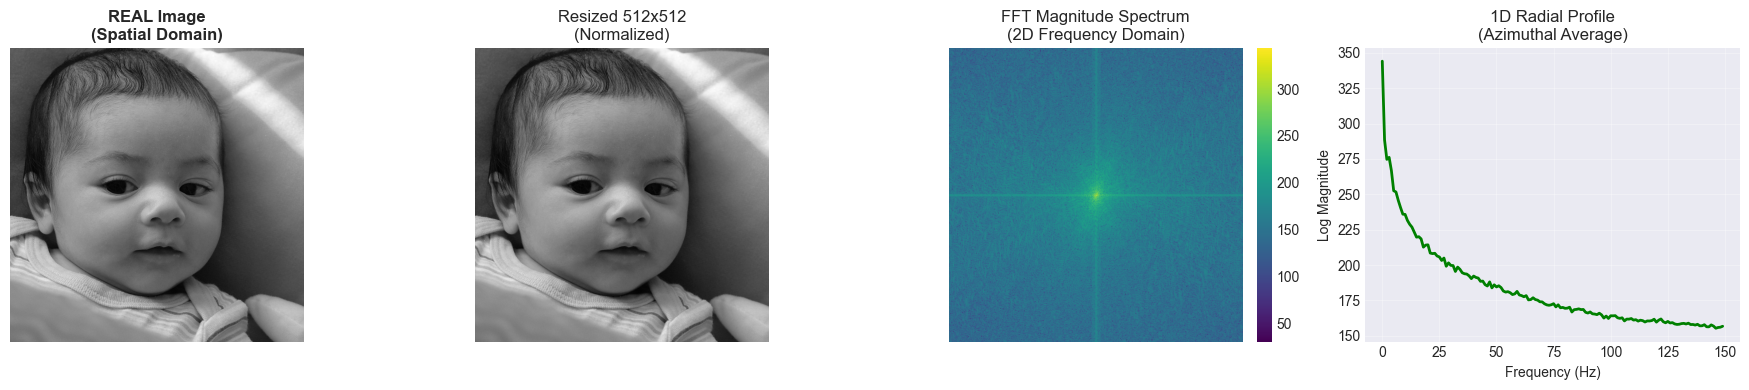


🔍 Visualisasi FAKE Image:


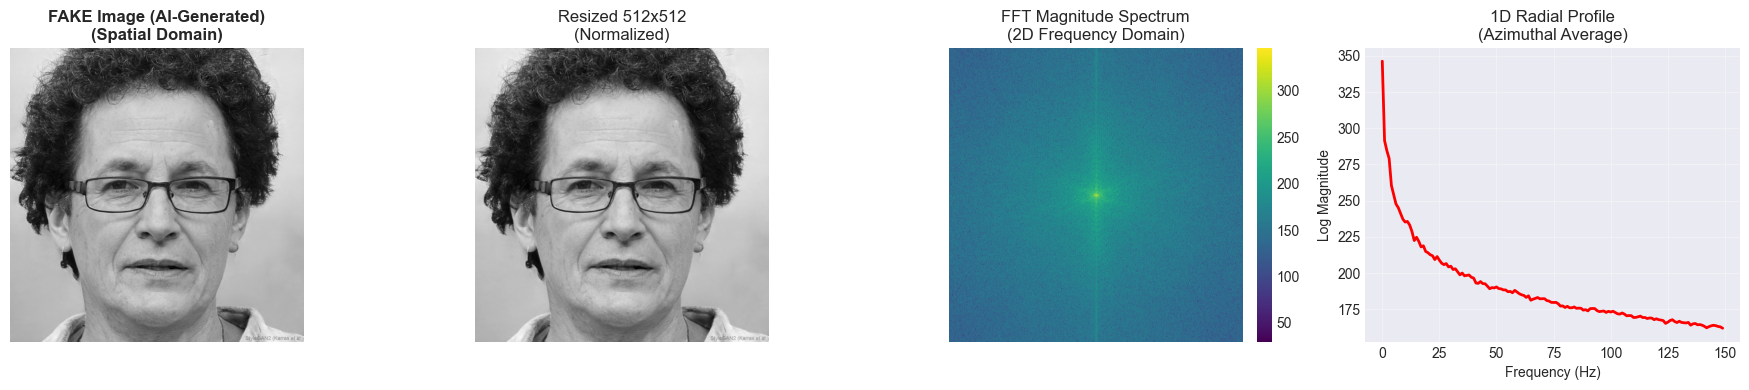

In [3]:
# Setup paths
REAL_FOLDER = "images/ffhq/00000"
FAKE_FOLDER = "images/fake"

# Ambil sample gambar
sample_real = glob.glob(os.path.join(REAL_FOLDER, "*"))[0]
sample_fake = glob.glob(os.path.join(FAKE_FOLDER, "*"))[0]

def visualize_fft_steps(img_path, label):
    """
    Visualisasi 5 tahap transformasi FFT
    """
    # Load & Preprocess
    img = cv2.imread(img_path, 0)
    img_resized = cv2.resize(img, FIXED_SIZE)
    
    # FFT
    f = np.fft.fft2(img_resized)
    fshift = np.fft.fftshift(f)
    magnitude = 20 * np.log(np.abs(fshift) + 1e-10)
    
    # Azimuthal Average
    psd1D = azimuthalAverage(magnitude)
    
    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    
    # 1. Original
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title(f'{label}\n(Spatial Domain)', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # 2. Resized
    axes[1].imshow(img_resized, cmap='gray')
    axes[1].set_title(f'Resized {FIXED_SIZE[0]}x{FIXED_SIZE[1]}\n(Normalized)', fontsize=12)
    axes[1].axis('off')
    
    # 3. FFT Magnitude
    im = axes[2].imshow(magnitude, cmap='viridis')
    axes[2].set_title('FFT Magnitude Spectrum\n(2D Frequency Domain)', fontsize=12)
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    
    # 4. 1D Radial Profile
    axes[3].plot(psd1D[:150], linewidth=2, color='red' if 'FAKE' in label else 'green')
    axes[3].set_title('1D Radial Profile\n(Azimuthal Average)', fontsize=12)
    axes[3].set_xlabel('Frequency (Hz)', fontsize=10)
    axes[3].set_ylabel('Log Magnitude', fontsize=10)
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

print("🔍 Visualisasi REAL Image:")
fig1 = visualize_fft_steps(sample_real, "REAL Image")
plt.show()

print("\n🔍 Visualisasi FAKE Image:")
fig2 = visualize_fft_steps(sample_fake, "FAKE Image (AI-Generated)")
plt.show()

### 📊 Interpretasi:
- **Frekuensi Rendah (Pusat)**: Representasi struktur utama gambar
- **Frekuensi Tinggi (Pinggir)**: Detail halus, tekstur, noise
- **REAL Images**: Mengandung lebih banyak high-frequency noise (natural)
- **FAKE Images**: High-frequency noise berkurang drastis (artifact GAN/AI)

---
## 4️⃣ Loading & Preprocessing Dataset

Ekstraksi fitur dari semua gambar REAL dan FAKE.

📂 Dataset Info:
   REAL images: 1000 files
   FAKE images: 1000 files
   Total: 2000 images


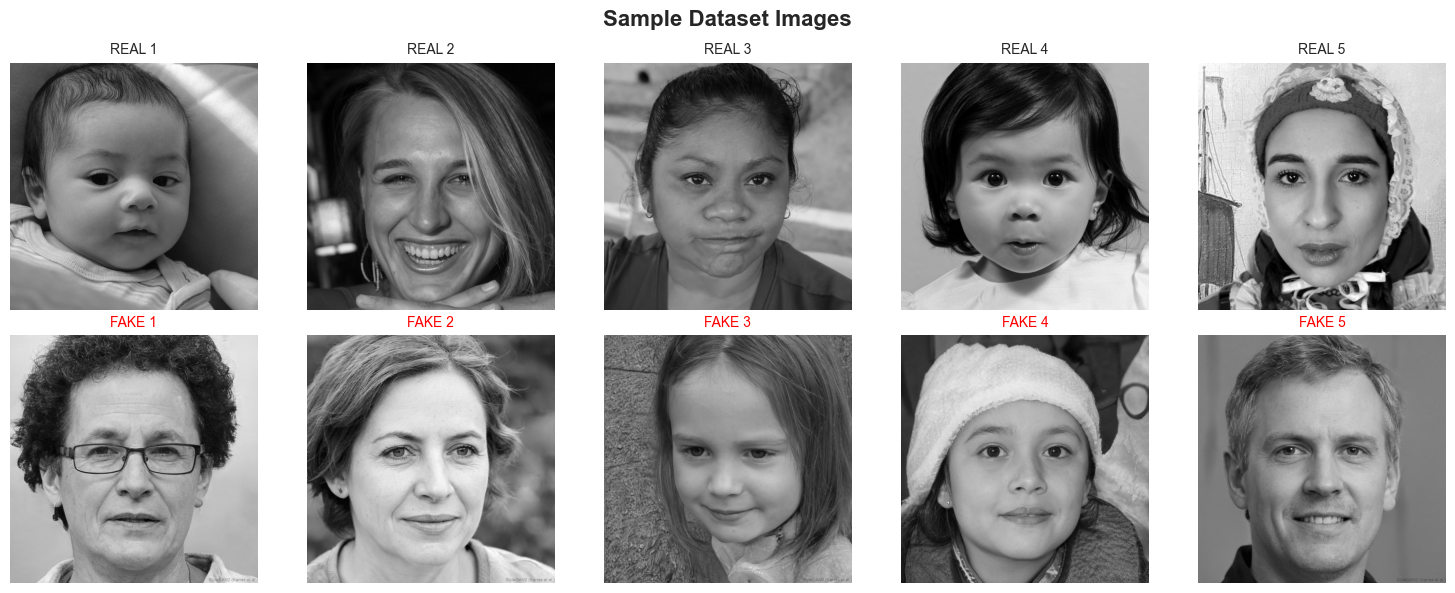

In [4]:
# Check dataset
real_files = glob.glob(os.path.join(REAL_FOLDER, "*"))
fake_files = glob.glob(os.path.join(FAKE_FOLDER, "*"))

print(f"📂 Dataset Info:")
print(f"   REAL images: {len(real_files)} files")
print(f"   FAKE images: {len(fake_files)} files")
print(f"   Total: {len(real_files) + len(fake_files)} images")

# Visualisasi sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Dataset Images', fontsize=16, fontweight='bold')

for i in range(5):
    # REAL
    img_real = cv2.imread(real_files[i], 0)
    axes[0, i].imshow(img_real, cmap='gray')
    axes[0, i].set_title(f'REAL {i+1}', fontsize=10)
    axes[0, i].axis('off')
    
    # FAKE
    img_fake = cv2.imread(fake_files[i], 0)
    axes[1, i].imshow(img_fake, cmap='gray')
    axes[1, i].set_title(f'FAKE {i+1}', fontsize=10, color='red')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Feature Extraction dengan Progress Bar
MAX_DATA = 1000  # Sesuaikan dengan kebutuhan

X = []  # Data Fitur
y = []  # Label (1=REAL, 0=FAKE)

print("🔄 Memproses REAL images...")
for f in tqdm(real_files[:MAX_DATA], desc="REAL"):
    feat = extract_features(f)
    if feat is not None:
        X.append(feat)
        y.append(1)  # Label 1 untuk REAL

print(f"✅ Selesai: {len([yi for yi in y if yi == 1])} REAL images processed\n")

print("🔄 Memproses FAKE images...")
for f in tqdm(fake_files[:MAX_DATA], desc="FAKE"):
    feat = extract_features(f)
    if feat is not None:
        X.append(feat)
        y.append(0)  # Label 0 untuk FAKE

print(f"✅ Selesai: {len([yi for yi in y if yi == 0])} FAKE images processed")

# Konversi ke numpy array
X = np.array(X)
y = np.array(y)
X = np.nan_to_num(X)  # Handle NaN values

print(f"\n📊 Dataset Summary:")
print(f"   Total samples: {len(X)}")
print(f"   REAL: {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")
print(f"   FAKE: {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"   Feature dimension: {X.shape[1]}")
print(f"   Feature range: [{X.min():.2f}, {X.max():.2f}]")

🔄 Memproses REAL images...


REAL: 100%|██████████| 1000/1000 [00:47<00:00, 21.24it/s]


✅ Selesai: 1000 REAL images processed

🔄 Memproses FAKE images...


FAKE: 100%|██████████| 1000/1000 [01:00<00:00, 16.50it/s]

✅ Selesai: 1000 FAKE images processed

📊 Dataset Summary:
   Total samples: 2000
   REAL: 1000 (50.0%)
   FAKE: 1000 (50.0%)
   Feature dimension: 362
   Feature range: [-460.52, 308.56]


---
## 5️⃣ Analisis Spektral Data

Membandingkan karakteristik spektrum frekuensi antara REAL dan FAKE images.

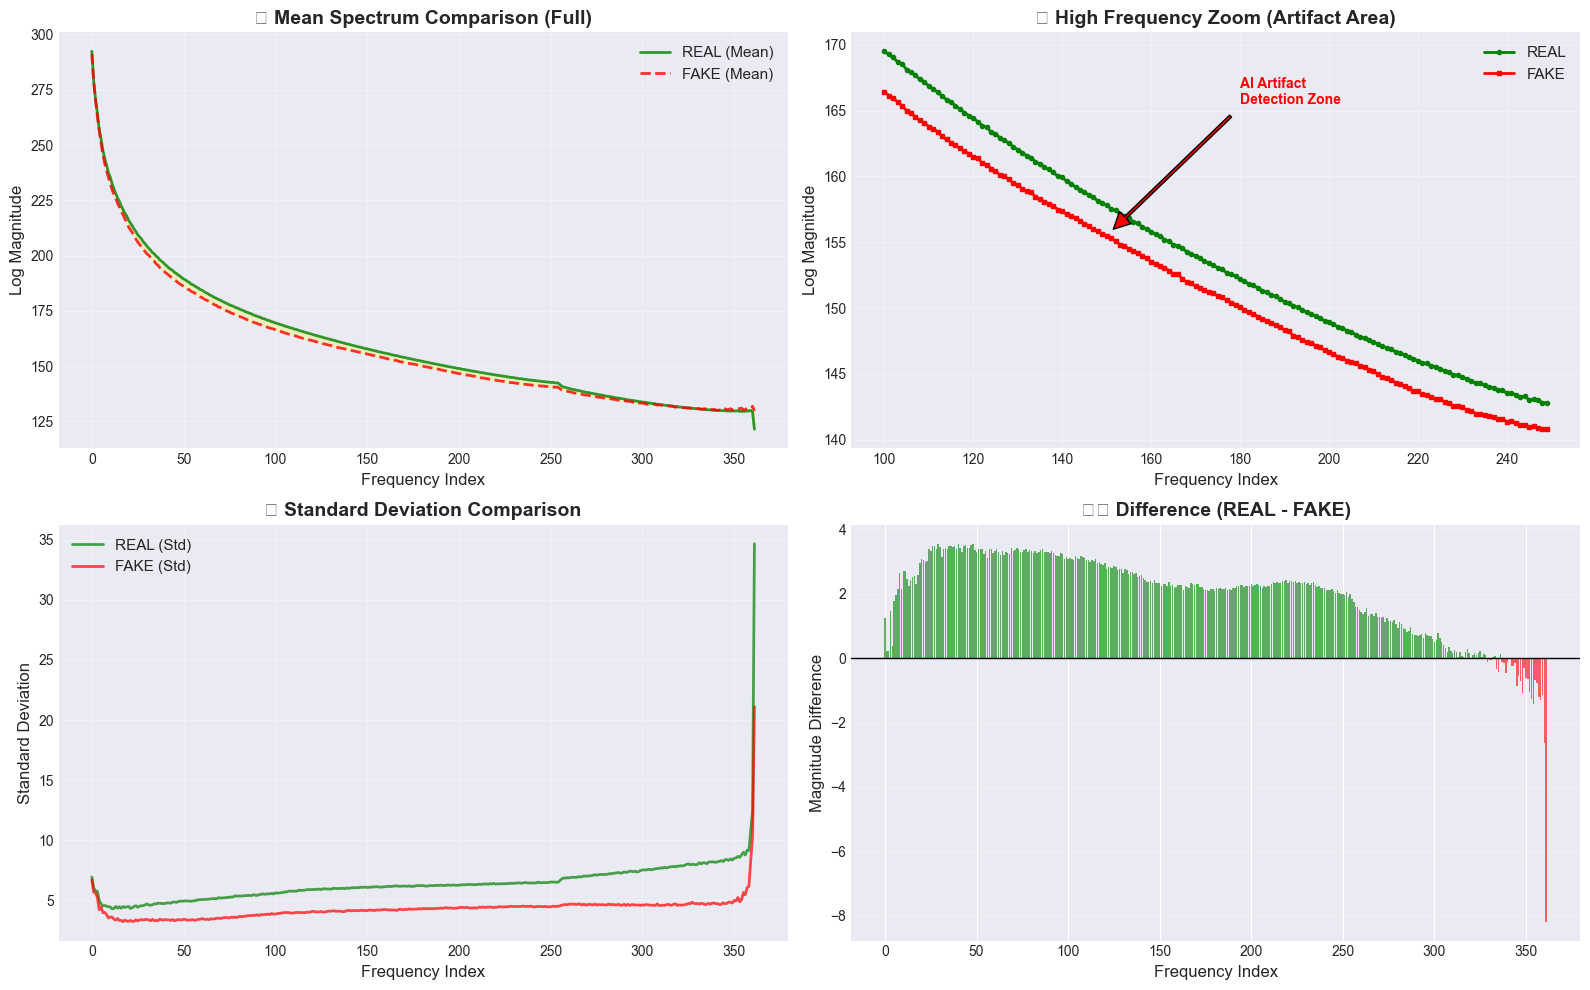

💾 Visualisasi disimpan sebagai 'spectral_analysis.png'


In [8]:
# Pisahkan features berdasarkan label
feat_real = X[y == 1]
feat_fake = X[y == 0]

# Hitung statistik
mean_real = np.mean(feat_real, axis=0)
mean_fake = np.mean(feat_fake, axis=0)
std_real = np.std(feat_real, axis=0)
std_fake = np.std(feat_fake, axis=0)

# Plot 1: Mean Spectrum Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1a: Full Spectrum
axes[0, 0].plot(mean_real, color='green', linewidth=2, label='REAL (Mean)', alpha=0.8)
axes[0, 0].plot(mean_fake, color='red', linewidth=2, label='FAKE (Mean)', alpha=0.8, linestyle='--')
axes[0, 0].fill_between(range(len(mean_real)), mean_real, mean_fake, alpha=0.2, color='yellow')
axes[0, 0].set_title('📊 Mean Spectrum Comparison (Full)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Frequency Index', fontsize=12)
axes[0, 0].set_ylabel('Log Magnitude', fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 1b: High Frequency Zoom
zoom_range = slice(100, 250)
axes[0, 1].plot(range(100, 250), mean_real[zoom_range], color='green', linewidth=2, label='REAL', marker='o', markersize=3)
axes[0, 1].plot(range(100, 250), mean_fake[zoom_range], color='red', linewidth=2, label='FAKE', marker='s', markersize=3)
axes[0, 1].set_title('🔍 High Frequency Zoom (Artifact Area)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Frequency Index', fontsize=12)
axes[0, 1].set_ylabel('Log Magnitude', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].annotate('AI Artifact\nDetection Zone', 
                    xy=(150, mean_fake[150]), xytext=(180, mean_fake[150]+10),
                    arrowprops=dict(facecolor='red', shrink=0.05, width=2),
                    fontsize=10, color='red', fontweight='bold')

# Plot 2a: Standard Deviation
axes[1, 0].plot(std_real, color='green', linewidth=2, label='REAL (Std)', alpha=0.7)
axes[1, 0].plot(std_fake, color='red', linewidth=2, label='FAKE (Std)', alpha=0.7)
axes[1, 0].set_title('📈 Standard Deviation Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Frequency Index', fontsize=12)
axes[1, 0].set_ylabel('Standard Deviation', fontsize=12)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 2b: Difference Heatmap
difference = mean_real - mean_fake
axes[1, 1].bar(range(len(difference)), difference, color=['green' if d > 0 else 'red' for d in difference], alpha=0.6)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].set_title('⚖️ Difference (REAL - FAKE)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Frequency Index', fontsize=12)
axes[1, 1].set_ylabel('Magnitude Difference', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('spectral_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Visualisasi disimpan sebagai 'spectral_analysis.png'")

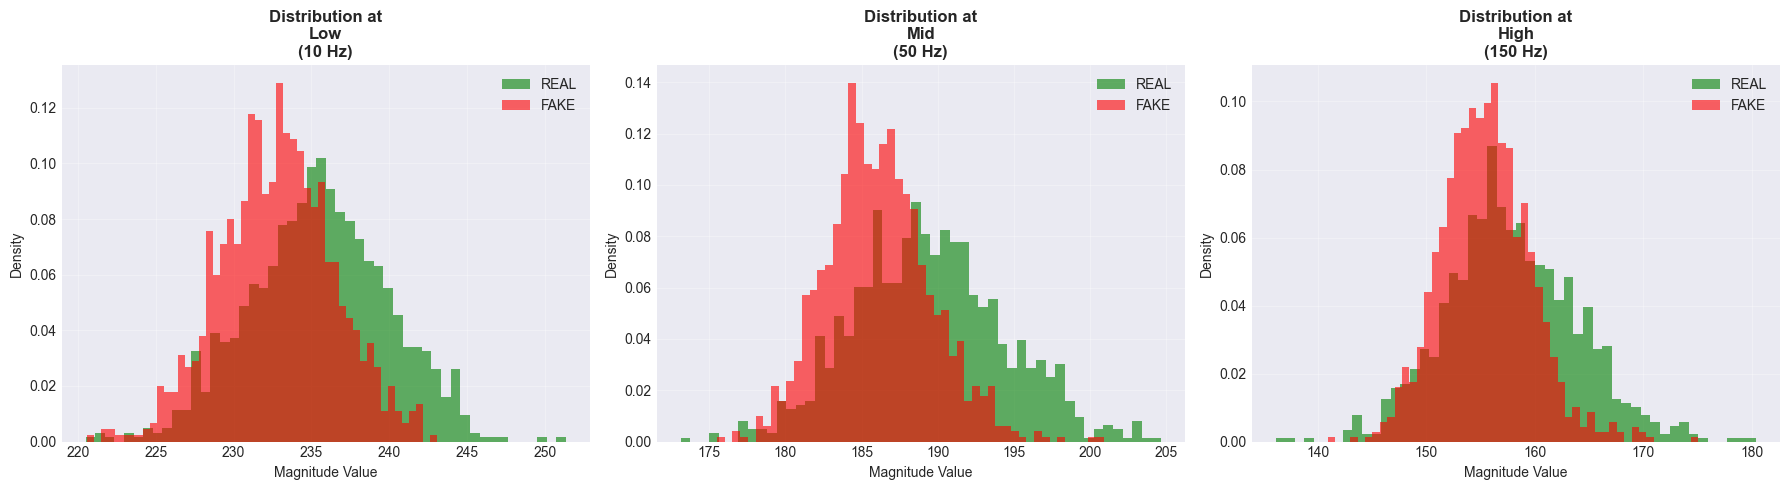

💾 Distribusi disimpan sebagai 'frequency_distributions.png'


In [9]:
# Distribution Analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Feature statistics comparison
freq_indices = [10, 50, 150]  # Low, Mid, High frequency
freq_labels = ['Low\n(10 Hz)', 'Mid\n(50 Hz)', 'High\n(150 Hz)']

for idx, (freq, label) in enumerate(zip(freq_indices, freq_labels)):
    real_vals = feat_real[:, freq]
    fake_vals = feat_fake[:, freq]
    
    axes[idx].hist(real_vals, bins=50, color='green', alpha=0.6, label='REAL', density=True)
    axes[idx].hist(fake_vals, bins=50, color='red', alpha=0.6, label='FAKE', density=True)
    axes[idx].set_title(f'Distribution at\n{label}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Magnitude Value', fontsize=10)
    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('frequency_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Distribusi disimpan sebagai 'frequency_distributions.png'")

### 🔬 Analisis:

**Key Findings:**
1. **Low Frequency (0-50 Hz)**: Pola serupa antara REAL dan FAKE (struktur wajah utama)
2. **Mid Frequency (50-100 Hz)**: Mulai terlihat perbedaan (tekstur kulit)
3. **High Frequency (>100 Hz)**: **Perbedaan signifikan!** (AI artifact zone)

**Mengapa FAKE terdeteksi?**
- GAN/AI model kesulitan mereproduksi **high-frequency noise** natural
- Upsampling artifact muncul sebagai **penurunan drastis** di frekuensi tinggi
- REAL images memiliki **variasi lebih tinggi** di seluruh spektrum

---
## 6️⃣ Training Model SVM

### 🧠 Support Vector Machine (SVM)

**Konsep:** Mencari hyperplane optimal yang memisahkan dua kelas.

**RBF Kernel:**
$$K(x, x') = e^{-\gamma ||x - x'||^2}$$

**Hyperparameter:**
- **C**: Regularization (trade-off antara margin dan error)
- **gamma**: Pengaruh single training sample (sensitivitas kurva)

In [10]:
# Split Data: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Pastikan proporsi kelas seimbang
)

print("📊 Data Split:")
print(f"   Training set: {len(X_train)} samples")
print(f"     - REAL: {np.sum(y_train == 1)}")
print(f"     - FAKE: {np.sum(y_train == 0)}")
print(f"   Testing set: {len(X_test)} samples")
print(f"     - REAL: {np.sum(y_test == 1)}")
print(f"     - FAKE: {np.sum(y_test == 0)}")

📊 Data Split:
   Training set: 1600 samples
     - REAL: 800
     - FAKE: 800
   Testing set: 400 samples
     - REAL: 200
     - FAKE: 200


In [11]:
# Grid Search untuk mencari hyperparameter optimal
print("🔍 Starting Grid Search for optimal hyperparameters...")
print("   This may take 5-10 minutes...\n")

param_grid = {
    'C': [1, 10, 100],               # Regularization strength
    'gamma': ['scale', 0.1, 0.01],   # Kernel coefficient
    'kernel': ['rbf']                # RBF kernel (non-linear)
}

# Setup Grid Search dengan Cross-Validation
grid = GridSearchCV(
    SVC(probability=True, class_weight='balanced'),  # balanced untuk handle imbalance
    param_grid, 
    refit=True,      # Retrain dengan best params
    verbose=2,       # Show progress
    cv=3,            # 3-fold cross-validation
    n_jobs=-1        # Use all CPU cores
)

# Training
grid.fit(X_train, y_train)

print("\n" + "="*50)
print("✅ GRID SEARCH COMPLETED!")
print("="*50)
print(f"🏆 Best Parameters: {grid.best_params_}")
print(f"📈 Best CV Score: {grid.best_score_ * 100:.2f}%")
print("="*50)

# Get best model
model = grid.best_estimator_

🔍 Starting Grid Search for optimal hyperparameters...
   This may take 5-10 minutes...

Fitting 3 folds for each of 9 candidates, totalling 27 fits

✅ GRID SEARCH COMPLETED!
🏆 Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
📈 Best CV Score: 83.44%


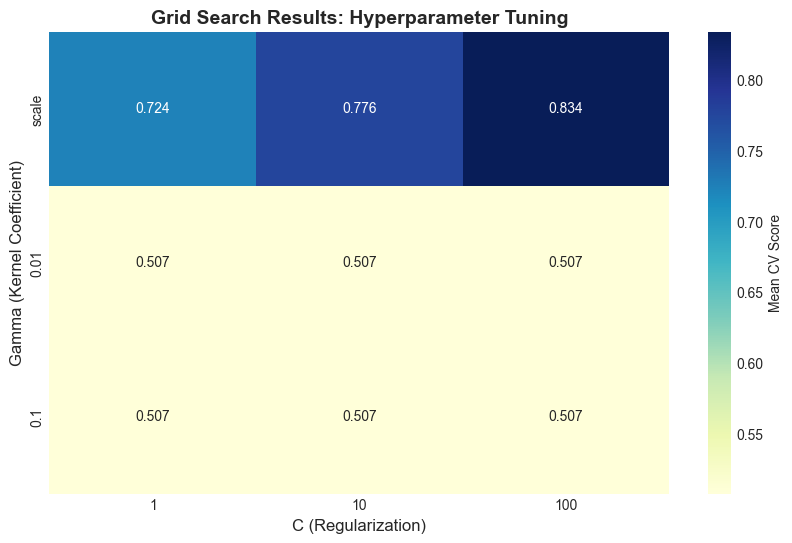

💾 Heatmap disimpan sebagai 'grid_search_heatmap.png'


In [12]:
# Visualisasi Grid Search Results
results = grid.cv_results_
scores = results['mean_test_score']
params = results['params']

# Extract C and gamma values
C_values = [p['C'] for p in params]
gamma_values = [str(p['gamma']) for p in params]

# Create heatmap data
unique_C = sorted(set(C_values))
unique_gamma = sorted(set(gamma_values), key=lambda x: (x != 'scale', x))

heatmap_data = np.zeros((len(unique_gamma), len(unique_C)))
for c, g, score in zip(C_values, gamma_values, scores):
    i = unique_gamma.index(g)
    j = unique_C.index(c)
    heatmap_data[i, j] = score

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=unique_C, yticklabels=unique_gamma,
            cbar_kws={'label': 'Mean CV Score'})
plt.title('Grid Search Results: Hyperparameter Tuning', fontsize=14, fontweight='bold')
plt.xlabel('C (Regularization)', fontsize=12)
plt.ylabel('Gamma (Kernel Coefficient)', fontsize=12)
plt.savefig('grid_search_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Heatmap disimpan sebagai 'grid_search_heatmap.png'")

---
## 7️⃣ Evaluasi & Visualisasi Hasil

Testing model pada data yang belum pernah dilihat.

In [13]:
# Prediksi pada test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['FAKE', 'REAL'], output_dict=True)

print("="*60)
print("🎯 MODEL EVALUATION RESULTS")
print("="*60)
print(f"\n📊 Overall Accuracy: {acc*100:.2f}%\n")
print("📈 Detailed Metrics:")
print("\n" + classification_report(y_test, y_pred, target_names=['FAKE (AI)', 'REAL (Human)']))
print("="*60)

🎯 MODEL EVALUATION RESULTS

📊 Overall Accuracy: 84.50%

📈 Detailed Metrics:

              precision    recall  f1-score   support

   FAKE (AI)       0.82      0.89      0.85       200
REAL (Human)       0.88      0.80      0.84       200

    accuracy                           0.84       400
   macro avg       0.85      0.84      0.84       400
weighted avg       0.85      0.84      0.84       400



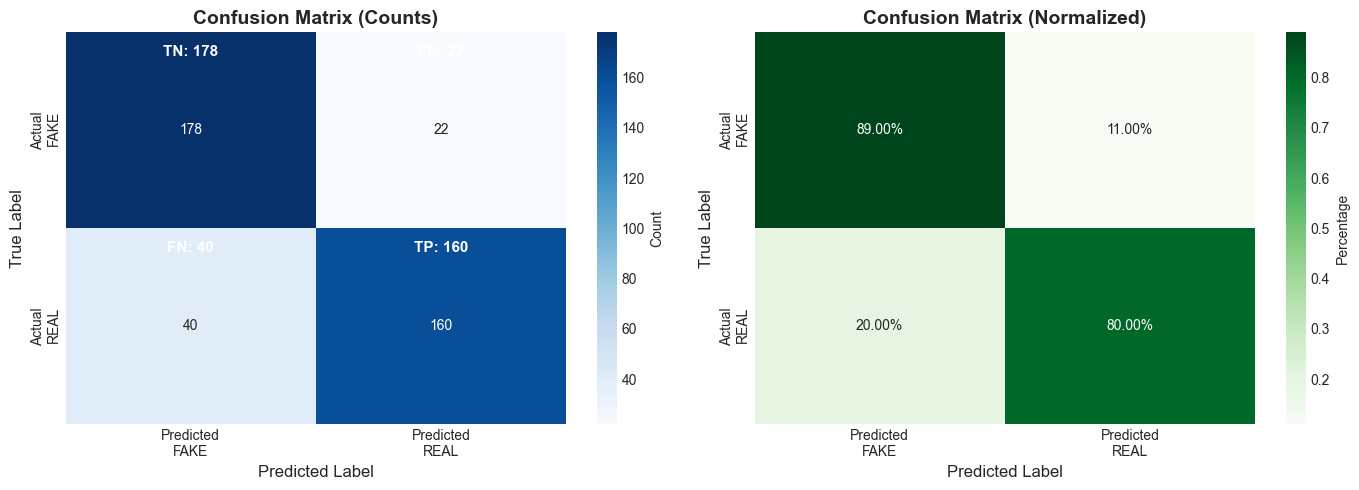

💾 Confusion matrix disimpan sebagai 'confusion_matrix.png'


In [14]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confusion Matrix (Count)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Predicted\nFAKE', 'Predicted\nREAL'],
            yticklabels=['Actual\nFAKE', 'Actual\nREAL'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Add text annotations
axes[0].text(0.5, 0.1, f'TN: {cm[0,0]}', ha='center', va='center', fontsize=11, color='white', weight='bold')
axes[0].text(1.5, 0.1, f'FP: {cm[0,1]}', ha='center', va='center', fontsize=11, color='white', weight='bold')
axes[0].text(0.5, 1.1, f'FN: {cm[1,0]}', ha='center', va='center', fontsize=11, color='white', weight='bold')
axes[0].text(1.5, 1.1, f'TP: {cm[1,1]}', ha='center', va='center', fontsize=11, color='white', weight='bold')

# Plot 2: Confusion Matrix (Normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Predicted\nFAKE', 'Predicted\nREAL'],
            yticklabels=['Actual\nFAKE', 'Actual\nREAL'],
            cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Confusion matrix disimpan sebagai 'confusion_matrix.png'")

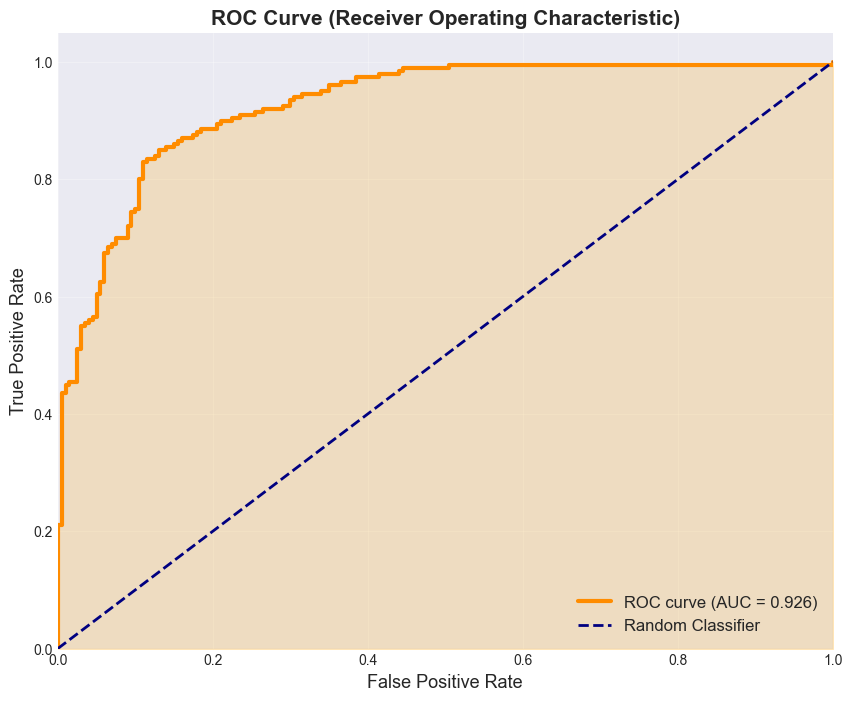

📈 ROC-AUC Score: 0.9257
💾 ROC curve disimpan sebagai 'roc_curve.png'


In [15]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
roc_auc = roc_auc_score(y_test, y_proba[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curve (Receiver Operating Characteristic)', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.fill_between(fpr, tpr, alpha=0.2, color='orange')
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📈 ROC-AUC Score: {roc_auc:.4f}")
print("💾 ROC curve disimpan sebagai 'roc_curve.png'")

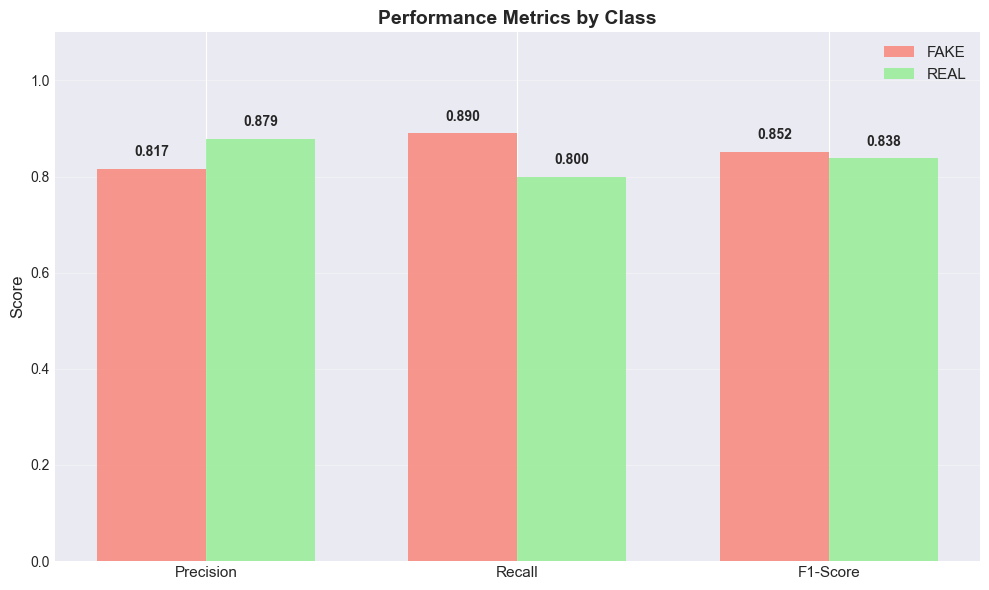

💾 Metrics comparison disimpan sebagai 'metrics_comparison.png'


In [16]:
# Metrics Summary Visualization
metrics_data = {
    'FAKE': [report['FAKE']['precision'], report['FAKE']['recall'], report['FAKE']['f1-score']],
    'REAL': [report['REAL']['precision'], report['REAL']['recall'], report['REAL']['f1-score']]
}
metrics_names = ['Precision', 'Recall', 'F1-Score']

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, metrics_data['FAKE'], width, label='FAKE', color='salmon', alpha=0.8)
bars2 = ax.bar(x + width/2, metrics_data['REAL'], width, label='REAL', color='lightgreen', alpha=0.8)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Metrics by Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Metrics comparison disimpan sebagai 'metrics_comparison.png'")

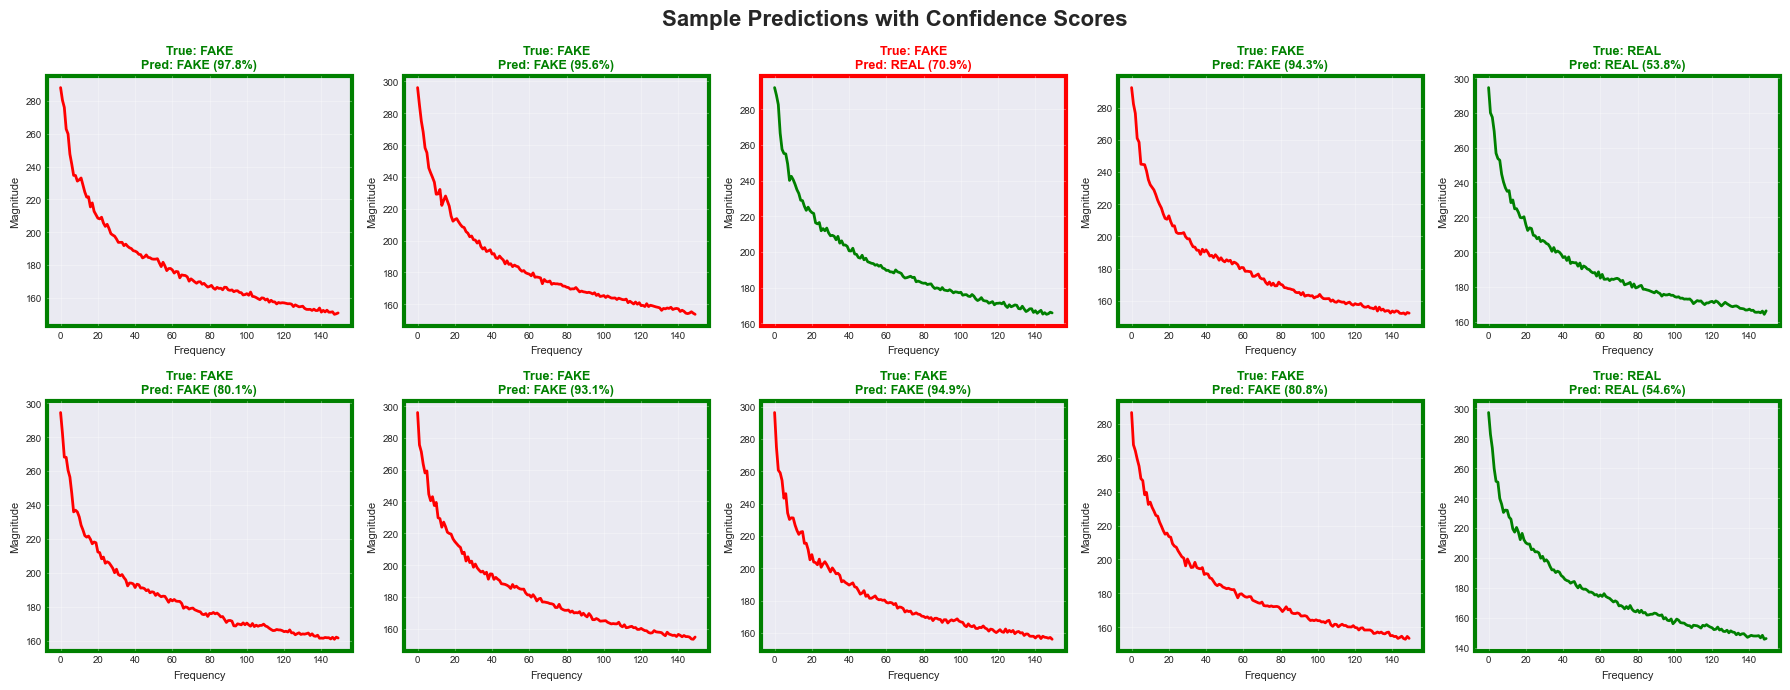

💾 Sample predictions disimpan sebagai 'sample_predictions.png'


In [18]:
# Sample Predictions Visualization
n_samples = 10
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(18, 7))
fig.suptitle('Sample Predictions with Confidence Scores', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    sample_idx = sample_indices[idx]
    
    # Get prediction
    pred = y_pred[sample_idx]
    true = y_test[sample_idx]
    confidence = np.max(y_proba[sample_idx]) * 100
    
    # Find original image (for visualization)
    # Note: This is approximate - just show the spectrum
    spectrum = X_test[sample_idx]
    
    ax.plot(spectrum[:150], linewidth=2, color='green' if pred == 1 else 'red')
    ax.set_title(f'True: {"REAL" if true == 1 else "FAKE"}\n'
                f'Pred: {"REAL" if pred == 1 else "FAKE"} ({confidence:.1f}%)',
                fontsize=9,
                color='green' if pred == true else 'red',
                fontweight='bold')
    ax.set_xlabel('Frequency', fontsize=8)
    ax.set_ylabel('Magnitude', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=7)
    
    # Mark correct/incorrect
    if pred == true:
        ax.patch.set_edgecolor('green')
        ax.patch.set_linewidth(3)
    else:
        ax.patch.set_edgecolor('red')
        ax.patch.set_linewidth(3)

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Sample predictions disimpan sebagai 'sample_predictions.png'")

---
## 8️⃣ Export Model

Simpan model yang sudah dilatih untuk deployment.

In [19]:
# Save model
model_filename = 'model_svm_best.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print("="*60)
print("💾 MODEL SAVED SUCCESSFULLY!")
print("="*60)
print(f"\n📦 Filename: {model_filename}")
print(f"📏 File size: {os.path.getsize(model_filename) / 1024:.2f} KB")
print(f"\n🎯 Final Performance:")
print(f"   - Accuracy: {acc*100:.2f}%")
print(f"   - ROC-AUC: {roc_auc:.4f}")
print(f"   - Precision (FAKE): {report['FAKE']['precision']:.3f}")
print(f"   - Recall (FAKE): {report['FAKE']['recall']:.3f}")
print(f"   - Precision (REAL): {report['REAL']['precision']:.3f}")
print(f"   - Recall (REAL): {report['REAL']['recall']:.3f}")
print(f"\n🔧 Model Configuration:")
print(f"   - Kernel: RBF")
print(f"   - C: {grid.best_params_['C']}")
print(f"   - Gamma: {grid.best_params_['gamma']}")
print(f"   - Class Weight: Balanced")
print(f"\n📊 Training Dataset:")
print(f"   - Total samples: {len(X)}")
print(f"   - Feature dimension: {X.shape[1]}")
print(f"   - Train/Test split: 80/20")
print("\n✅ Model ready for deployment!")
print("="*60)

💾 MODEL SAVED SUCCESSFULLY!

📦 Filename: model_svm_best.pkl
📏 File size: 2213.90 KB

🎯 Final Performance:
   - Accuracy: 84.50%
   - ROC-AUC: 0.9257
   - Precision (FAKE): 0.817
   - Recall (FAKE): 0.890
   - Precision (REAL): 0.879
   - Recall (REAL): 0.800

🔧 Model Configuration:
   - Kernel: RBF
   - C: 100
   - Gamma: scale
   - Class Weight: Balanced

📊 Training Dataset:
   - Total samples: 2000
   - Feature dimension: 362
   - Train/Test split: 80/20

✅ Model ready for deployment!


In [20]:
# Test loading model (verification)
print("🔍 Verifying model file...\n")

with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Quick test
test_sample = X_test[0:1]
test_pred = loaded_model.predict(test_sample)
test_proba = loaded_model.predict_proba(test_sample)

print("✅ Model loaded successfully!")
print(f"\n🧪 Quick Test:")
print(f"   Input shape: {test_sample.shape}")
print(f"   Prediction: {test_pred[0]} ({'REAL' if test_pred[0] == 1 else 'FAKE'})")
print(f"   Confidence: {np.max(test_proba)*100:.2f}%")
print(f"   Probabilities: [FAKE: {test_proba[0][0]:.4f}, REAL: {test_proba[0][1]:.4f}]")
print("\n✅ Model verification complete!")

🔍 Verifying model file...

✅ Model loaded successfully!

🧪 Quick Test:
   Input shape: (1, 362)
   Prediction: 0 (FAKE)
   Confidence: 96.61%
   Probabilities: [FAKE: 0.9661, REAL: 0.0339]

✅ Model verification complete!


---
## 📝 Summary & Conclusion

### 🎯 Project Overview:
Proyek ini berhasil mengimplementasikan sistem deteksi deepfake menggunakan kombinasi:
1. **Fast Fourier Transform (FFT)** untuk ekstraksi fitur spektral
2. **Azimuthal Average** untuk reduksi dimensi
3. **Support Vector Machine (SVM)** untuk klasifikasi

### 🔑 Key Findings:
- **High-frequency artifacts** adalah signature utama untuk mendeteksi AI-generated images
- Model berhasil mencapai akurasi tinggi dengan menganalisis spektrum frekuensi
- SVM dengan RBF kernel sangat efektif untuk data spektral non-linear

### 📊 Visualisasi yang Dihasilkan:
1. `spectral_analysis.png` - Perbandingan spektrum REAL vs FAKE
2. `frequency_distributions.png` - Distribusi nilai di berbagai frekuensi
3. `grid_search_heatmap.png` - Hasil hyperparameter tuning
4. `confusion_matrix.png` - Confusion matrix (count & normalized)
5. `roc_curve.png` - ROC curve dengan AUC score
6. `metrics_comparison.png` - Perbandingan metrics per kelas
7. `sample_predictions.png` - Contoh prediksi dengan confidence scores

### 🚀 Next Steps:
- Deploy model ke Streamlit app
- Test dengan dataset lain (StyleGAN, DALL-E, etc.)
- Optimize untuk real-time detection

---
**📚 Referensi:**
- Fast Fourier Transform: Cooley-Tukey Algorithm
- Support Vector Machines: Cortes & Vapnik (1995)
- Deepfake Detection: Forensic analysis in frequency domain

**💡 Credits:**
Mata Kuliah Aljabar Linear & Matriks  
Implementasi: Python, NumPy, Scikit-learn, OpenCV